# Proyecto Final Algebra Lineal 2017
---

El proyecto del curso consiste en la implementación del [Algortimo de Canny](https://es.wikipedia.org/wiki/Algoritmo_de_Canny) para la detección de bordes en imágenes y videos. Para ello, se le entrega al estudiante toda la implementación del algoritmo en [OpenCV](http://opencv.org/) y su objetivo es **implementar las funciones de OpenCV con matrices**. 

Las funciones a modificar serán las siguientes:
```python
cv2.GaussianBlur()
cv2.Sobel()
```

No es necesario que modifique más del código que se le solicita, pero puede hacer las modificaciones pertinentes si ese fuera el caso. Dentro del código se le indica en qué parte debe de ser modificado, por ejemplo:

```python
'''Modificar esta función'''
    sobel = cv2.Sobel(img, cv2.CV_64F, x, y, ksize=sobel_kernel)
``` 

Se recomienda buscar maneras de optimizar los cálculos de sus filtros, pues más adelante existe una aplicación en tiempo real donde es crucial que sus cálculos sean lo más rápidos posibles. Las dimensiones de los *kernels* no pueden ser modificadas.

## 0. Conceptos
Para poder modificar las funciones solicitadas es necesario que comprenda algunos conceptos, por lo cual es necesario que defina:

1. ¿En que consiste la convolución y cómo puede ser calculada? (Puede dar una definición matemática y/o ejemplos).

2. ¿Qué es el *kernel* de un filtro y para que se utiliza?

3. ¿En qué consiste un filtro Gaussiano?

4. ¿En qué consiste el Filtro Sobel? ¿para qué sirve?

3. Describa el algoritmo de detección de bordes Canny.

In [12]:
import numpy as np
import matplotlib.pylab as plt
import cv2
import math

#extras
from PIL import Image
import time
#from scipy.misc import toimage
#-----------------------------------

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [2]:
def gaussian_kernel():
    '''My function'''
    kernel = np.matrix([[1,4,7,4,1],[4,20,33,20,4],[7,33,55,7,33],[4,20,33,20,4],[1,4,7,4,1]])*0.003663004
    #kernel = np.matrix([[1,4,7,4,1],[4,16,26,16,4],[7,26,41,26,7],[4,16,26,16,4],[1,4,7,4,1]])
    return kernel

def sobelx_kernel():
    '''My function'''
    #kernel = np.matrix([[-3,0,3],[-10,0,10],[-3,0,3]])
    #kernel = np.matrix([[-5,0,5],[-12, 0, 12],[-5,0,5]])
    kernel = np.matrix([[1, 0, -1],[2, 0, -2], [1, 0, -1]])
    #kernel = np.matrix([[-1, 0,+1],[-2,0,2],[-1,0,1]])
    return kernel
def sobely_kernel():
    '''My function'''
    #kernel = np.matrix([[-3,-10,-3],[0,0,0],[3,10,3]])
    #kernel = np.matrix([[-5, -12,-5],[0,0,0],[5,12,5]])
    kernel = np.matrix([[1, 2, 1], [0, 0, 0],[-1, -2, -1]])
    #kernel = np.matrix([[1, 2,1],[0,0,0],[-1,-2,-2]])
    return kernel

def convolution(img, kernel):
    difference = int(math.floor(kernel.shape[0]/2))
    new_img = np.zeros((img.shape[0]-difference, img.shape[1]-difference))
    kernel_sum = np.sum(np.abs(kernel))
    for row in range(difference, img.shape[0]-difference):
        for column in range(difference, img.shape[1]-difference):
            #create the current pixel matrix
            current_matrix = np.matrix(img[row-difference:row+difference+1, column-difference: column+difference+1])
            #current matrix is multiplicated with the kernel, element to element
            current_matrix = np.multiply(current_matrix, kernel)
            #summing current matrix elements
            current_sum = np.sum(current_matrix)
            #dividing the current sum and kernel sum and sustituded and replacing the pixel value
            new_img[row-difference, column-difference] = current_sum/kernel_sum
    return new_img

def double_convolution(img, kernelx, kernely):
    #it assume the kernel is square and dim(kernelx) = dim(kernely)
    difference = int(math.floor(kernelx.shape[0]/2))
    #x elements
    kernelx_sum = np.sum(np.abs(kernelx))
    img_x = np.zeros((img.shape[0]-difference, img.shape[1]-difference))
    #y elements
    kernely_sum = np.sum(np.abs(kernely))
    img_y = np.zeros((img.shape[0]-difference, img.shape[1]-difference))
    
    for row in range(difference, img.shape[0]-difference):
        for column in range(difference, img.shape[1]-difference):
            #create the current pixel matrix
            current_matrix = np.matrix(img[row-difference:row+difference+1, column-difference: column+difference+1])
            #current matrix is multiplicated with the kernel, element to element
            currentx = np.multiply(current_matrix, kernelx)
            currenty = np.multiply(current_matrix,kernely)
            #summing current matrix elements
            sum_x = np.sum(currentx)
            sum_y = np.sum(currenty)
            #dividing the current sum and kernel sum and sustituded and replacing the pixel value
            img_x[row-difference, column-difference] = sum_x/kernelx_sum
            img_y[row-difference, column-difference] = sum_y/kernely_sum
    return np.array([img_x,img_y])

def gaussian_blur(img, kernel=5):
    return convolution(img, gaussian_kernel()) #return cv2.GaussianBlur(img,(kernel,kernel),0)
    
    
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    '''Modificar esta función'''
   #sobel = cv2.Sobel(img, cv2.CV_64F, x, y, ksize=sobel_kernel) 
    if orient == 'x':
        sobel = convolution(img, sobelx_kernel())
    elif orient == 'y':
        sobel = convolution(img, sobely_kernel())
            
    
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)

    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sbinary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Take the gradient in x and y separately
    
    sobel_results = double_convolution(image, sobelx_kernel(), sobely_kernel())
    
    '''Modificar esta función'''
   #sobelx = convolution(image, sobelx_kernel()) #sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelx = sobel_results[0]
    '''Modificar esta función'''
    #sobely = convolution(image, sobely_kernel()) #sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobely = sobel_results[1]
    # Calculate the magnitude 
    abs_sobel = np.sqrt(sobelx**2 +sobely**2)

    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a binary mask where mag thresholds are met
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return sbinary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Take the gradient in x and y separately 
    
    sobel_results = double_convolution(image, sobelx_kernel(), sobely_kernel())
    '''Modificar esta función'''
    #sobelx = convolution(image, sobelx_kernel()) #sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelx = sobel_results[0]
    '''Modificar esta función'''
    #sobely = convolution(image, sobely_kernel())#sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobely = sobel_results[1]
    
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)   
    abs_sobely = np.absolute(sobely)
    
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    # Create a binary mask where direction thresholds are met
    sbinary = np.zeros_like(grad_dir)
    sbinary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return sbinary

## Algorithms test 

Conv1D function took 4220.000 ms


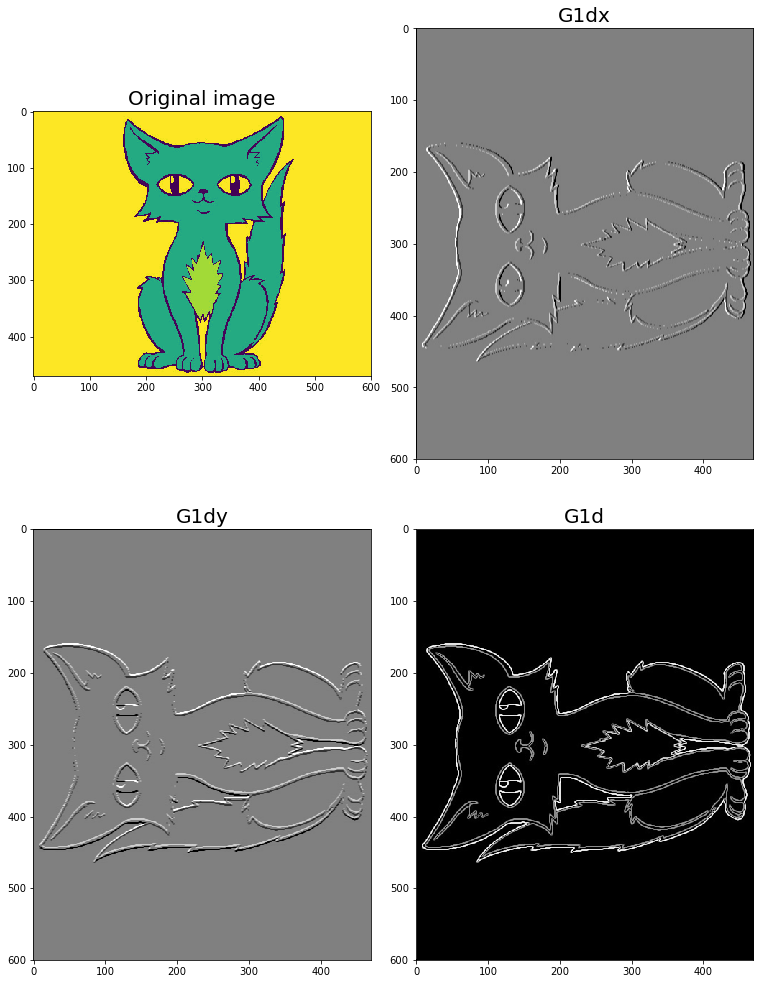

In [7]:
#CONVOLUTION 1

i = Image.open('Gato.jpg')
width, height = i.size

im = np.array(Image.open('Gato.jpg'))
im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
im1 = Image.fromarray(im, 'L')

convx = np.array([[1, 0, -1],
                     [2, 0, -2],
                     [1, 0, -1]])

convy = np.array([[1, 2, 1],
                     [0, 0, 0],
                     [-1, -2, -1]])

convxr=np.array([1, 0, -1])

convxc=np.array([[1],
                    [2],
                    [1]])

convyr=np.array([1, 2, 1])

convyc=np.array([[1],
                    [0],
                    [-1]])

image = np.zeros(shape=(width + 2, height + 2), dtype=int)
image1 = np.array(image)

for m in range(0, width - 1):
    for n in range(0, height - 1):
        image1[m + 1, n + 1] = im[n,m] #im[m, n]



G1d = np.zeros(shape=(width, height), dtype=int)
G1d = np.array(G1d)

time1dstart = time.time()

G1dx=conv1d(width + 2, height + 2, image1, convxc, convxr)
G1dy=conv1d(width + 2, height + 2, image1, convyc, convyr)

for x in range(0, width-1):
        for y in range(0, height-1):
            G1d[x,y]=math.sqrt(G1dx[x,y]*G1dx[x,y]+G1dy[x,y]*G1dy[x,y])
            
time1dend = time.time()

print('Conv1D function took %0.3f ms' %((time1dend-time1dstart)*1000.0))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 15))
f.tight_layout()
ax1.imshow(im)
ax1.set_title('Original image', fontsize=20)
ax2.imshow(G1dx, cmap='gray')
ax2.set_title('G1dx', fontsize=20)
ax3.imshow(G1dy, cmap='gray')
ax3.set_title('G1dy', fontsize=20)
ax4.imshow(G1d, cmap='gray')
ax4.set_title('G1d', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show() 

Conv2D function took 22150.000 ms


NameError: name 'G2d' is not defined

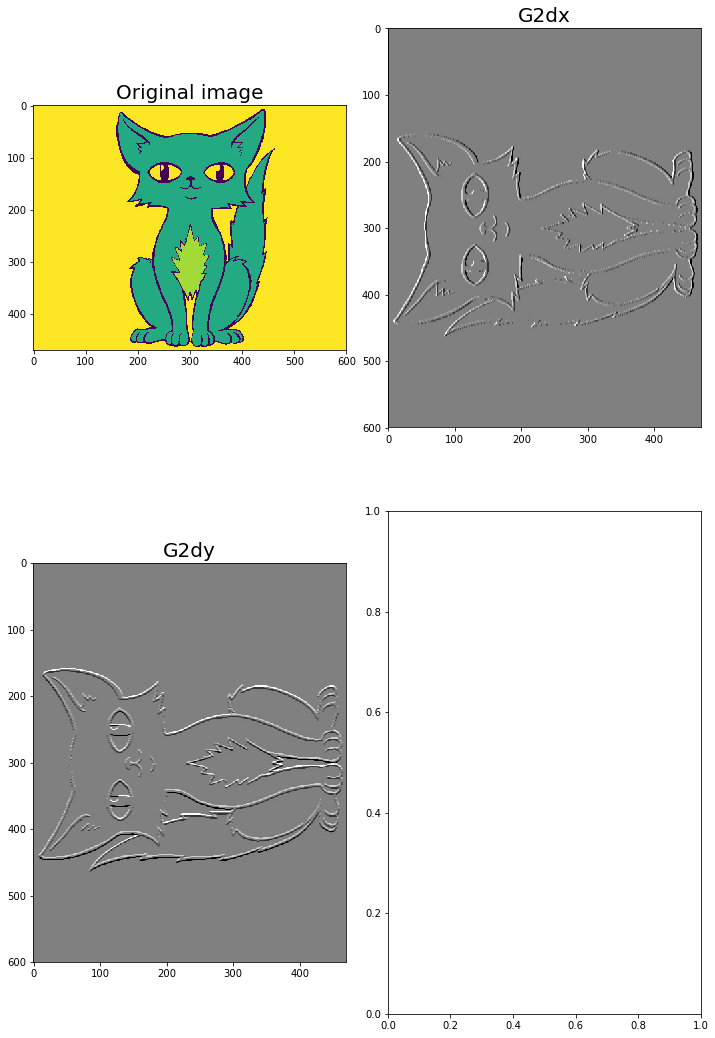

In [8]:
#CONVOLUTION 2

i = Image.open('Gato.jpg')
im = np.array(i)
im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
width,height = i.size

# x components
convx = sobelx_kernel()
#y components
convy = sobely_kernel()



image1 = np.zeros(shape=(width + 2, height + 2), dtype=int)

for m in range(0, width - 1):
    for n in range(0, height - 1):
        image1[m + 1, n + 1] = im[n,m]



time2dstart = time.time()

G2dx=conv2d(width + 2, height + 2, image1, convx)
G2dy=conv2d(width + 2, height + 2, image1, convy)


time2dend = time.time()

print('Conv2D function took %0.3f ms' %((time2dend-time2dstart)*1000.0))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 15))
f.tight_layout()
ax1.imshow(im)
ax1.set_title('Original image', fontsize=20)
ax2.imshow(G2dx, cmap='gray')
ax2.set_title('G2dx', fontsize=20)
ax3.imshow(G2dy, cmap='gray')
ax3.set_title('G2dy', fontsize=20)
ax4.imshow(G2d, cmap='gray')
ax4.set_title('G2d', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show() 

In [17]:
#methods for sobel filter

def conv1_sobel(w, h, image, convc, convr): 
    #this method uses a vertical and horizontal R1 kernel
    image2 = np.zeros(shape=(w, h), dtype=int)
    image2 = np.array(image2)
    for x in range(1, w - 2):
        for y in range(1, h - 2):
            image2[x, y] = (image[x - 1, y] * convc[0, 0] + image[x, y] * convc[1,0] + image[x + 1, y] * convc[2, 0])
    image3 = np.zeros(shape=(width, height), dtype=int)
    image3 = np.array(image3)
    for x in range(1, w - 2):
        for y in range(1, h - 2):
            image3[x-1, y-1] = (image2[x, y-1] * convr[0] + image2[x, y] * convr[1] + image2[x, y+1] * convr[2])
            if (image3[x, y] < 0):
                image3[x, y] =-image3[x,y]
    return np.rot90(image3,3)

def conv2_sobel(w, h, image, conv):
    #this method uses a conventional kernel, its operations are not done with methods of some class
    image2 = np.zeros(shape=(width, height), dtype=int)
    image2 = np.array(image2)
    for x in range(1, w - 2):
        for y in range(1, h - 2):
            image2[x-1, y-1] = (image[x - 1, y - 1] * conv[0, 0] + image[x - 1, y] * conv[0, 1] + image[x - 1, y + 1] * conv[0, 2] +
                                image[x, y - 1] * conv[1, 0] + image[x, y] * conv[1, 1] + image[x, y + 1] * conv[1, 2] +
                                image[x + 1, y - 1] * conv[2, 0] + image[x + 1, y] * conv[2, 1] + image[x + 1, y + 1] * conv[2, 2])
            if (image2[x, y] < 0):
                image2[x, y] =-image2[x,y]
    return np.rot90(image2,3)

def conv3_sobel(img, kernelx, kernely):
    #this method returns sobely and sobelx at the same time
    #it assume the kernel is square and dim(kernelx) = dim(kernely)
    difference = int(math.floor(kernelx.shape[0]/2))
    #x elements
    kernelx_sum = np.sum(np.abs(kernelx))
    img_x = np.zeros((img.shape[0]-difference, img.shape[1]-difference))
    #y elements
    kernely_sum = np.sum(np.abs(kernely))
    img_y = np.zeros((img.shape[0]-difference, img.shape[1]-difference))
    
    for row in range(difference, img.shape[0]-difference):
        for column in range(difference, img.shape[1]-difference):
            #create the current pixel matrix
            current_matrix = np.matrix(img[row-difference:row+difference+1, column-difference: column+difference+1])
            #current matrix is multiplicated with the kernel, element to element
            currentx = np.multiply(current_matrix, kernelx)
            currenty = np.multiply(current_matrix,kernely)
            #summing current matrix elements
            sum_x = np.sum(currentx)
            sum_y = np.sum(currenty)
            #dividing the current sum and kernel sum and sustituded and replacing the pixel value
            img_x[row-difference, column-difference] = sum_x/kernelx_sum
            img_y[row-difference, column-difference] = sum_y/kernely_sum
    return np.array([img_x,img_y])

def convolution(img, kernel):
    #It is a conventional convolution, this method was used for the gaussian kernel, 
    #but also was tested for the sobel filter
    difference = int(math.floor(kernel.shape[0]/2))
    new_img = np.zeros((img.shape[0]-difference, img.shape[1]-difference))
    kernel_sum = np.sum(np.abs(kernel))
    for row in range(difference, img.shape[0]-difference):
        for column in range(difference, img.shape[1]-difference):
            #create the current pixel matrix
            current_matrix = np.matrix(img[row-difference:row+difference+1, column-difference: column+difference+1])
            #current matrix is multiplicated with the kernel, element to element
            current_matrix = np.multiply(current_matrix, kernel)
            #summing current matrix elements
            current_sum = np.sum(current_matrix)
            #dividing the current sum and kernel sum and sustituded and replacing the pixel value
            new_img[row-difference, column-difference] = current_sum/kernel_sum
    return new_img

In [18]:
#test
i = Image.open('Gato.jpg')
im = cv2.cvtColor(np.array(i), cv2.COLOR_RGB2GRAY)
width,height = i.size

image1 = np.zeros(shape=(width + 2, height + 2), dtype=int)

for m in range(0, width - 1):
    for n in range(0, height - 1):
        image1[m + 1, n + 1] = im[n,m]
        
x_kernel = sobelx_kernel()
y_kernel = sobely_kernel()

#....method 1
time_start = time.time()
G1dx=conv1_sobel(width + 2, height + 2, image1, np.array(x_kernel[0:3,0:1]), np.array(x_kernel[0:1,0:3])[0])
G1dy=conv1_sobel(width + 2, height + 2, image1, np.array(y_kernel[0:3,0:1]), np.array(y_kernel[0:1,0:3])[0])
time_end = time.time()
print('Conv1S function: %0.3f ms' %((time_end-time_start)*1000.0))
#... method 2
time_start = time.time()
G2dx=conv2_sobel(width + 2, height + 2, image1, x_kernel)
G2dy=conv2_sobel(width + 2, height + 2, image1, y_kernel)
time_end = time.time()
print('Conv2S function: %0.3f ms' %((time_end-time_start)*1000.0))
#... method 3
time_start = time.time()
sobelxy = conv3_sobel(image1, x_kernel, y_kernel)
G2dx=sobelxy[0]
G2dy=sobelxy[1]
time_end = time.time()
print('Conv3S function: %0.3f ms' %((time_end-time_start)*1000.0))
#... method 4
time_start = time.time()

G2dx = convolution(image1, x_kernel)
G2dy = convolution(image1, y_kernel)
time_end = time.time()
print('Conv function: %0.3f ms' %((time_end-time_start)*1000.0))


Conv1S function: 3202.000 ms
Conv2S function: 21051.000 ms
Conv3S function: 22890.000 ms
Conv function: 27812.000 ms


In [ ]:
def sobel(img):
    sobel_x = sobelx_kernel()
    sobel_y = sobely_kernel()
    newimg = np.zeros((img.shape[0], img.shape[1]))
    
    for x in range (1, img.shape[0]-2):
        for y in range(1, img.shape[1]-2):
            pixel_x = (sobel_x[0,0] * img[x-1,y-1]) + (sobel_x[0,1] * img[x,y-1]) + (sobel_x[0,2] * img[x+1,y-1]) 
            + (sobel_x[1,0] * img[x-1,y])   + (sobel_x[1,1] * img[x,y])   + (sobel_x[1,2] * img[x+1,y]) 
            + (sobel_x[2,0] * img[x-1,y+1]) + (sobel_x[2,1] * img[x,y+1]) + (sobel_x[2,2] * img[x+1,y+1])

            pixel_y = (sobel_y[0,0] * img[x-1,y-1]) + (sobel_y[0,1] * img[x,y-1]) + (sobel_y[0,2] * img[x+1,y-1])
            +(sobel_y[1,0] * img[x-1,y])   + (sobel_y[1,1] * img[x,y])   + (sobel_y[1,2] * img[x+1,y]) 
            +(sobel_y[2,0] * img[x-1,y+1]) + (sobel_y[2,1] * img[x,y+1]) + (sobel_y[2,2] * img[x+1,y+1])

        val = math.ceil(math.sqrt((pixel_x * pixel_x) + (pixel_y * pixel_y)))
        newimg[x,y] = val
    return newimg

im = plt.imread("Gato.jpg")
gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
gray = gaussian_blur(gray, kernel = 5)
f, ((ax1))=plt.subplots(1,1, figsize=(10,15))
f.tight_layout()
ax1.imshow(sobel(gray))

In [ ]:
#test cell
im = plt.imread("Gato.jpg")
gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
gray = gaussian_blur(gray, kernel = 5)

f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10, 15))
f.tight_layout()
ax1.imshow(im)


sobelx = sobel_filter(gray, 'x')
sobely = sobel_filter(gray, 'y')
ax2.imshow(sobelx,cmap='gray')
ax3.imshow(sobely, cmap='gray')
ax4.imshow(sobelx+sobely, cmap='gray')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show() 

In [ ]:
#It is not fuctional v: --------------------------------------------------------------------------------
def boxBlurT_4 (scl, tcl, w, h, r):
    iarr = 1 / (r+r+1);
    for i in range (0, w):
        ti = i
        li = ti
        ri = ti+r*w
        fv = scl[ti]
        lv = scl[ti+w*(h-1)]
        val = (r+1)*fv
        for j in range(0,r):
            val = scl[ti+j*w] + val
            for j in range(0,r+1):
                print(ri) 
                val += scl[ri] - fv
                tcl[ti] = Math.round(val*iarr)
                ri+=w 
                ti+=w
                for j in range (r+1, h-r):
                    val = scl[ri] - scl[li] + val  
                    tcl[ti] = Math.round(val*iarr)
                    li+=w
                    ri+=w
                    ti+=w
                    for j in range(h-r, h):
                        val = lv   - scl[li] + val;  
                        tcl[ti] = Math.round(val*iarr);  
                        li+=w 
                        ti+=w
    print ('source channel: '+scl)
    print ('target channel: '+tcl)
    print ('width: '+w)
    print ('heigth: '+h)
    print ('radius: '+r)
    
scl = [78,65,0,36,92,3,45,8,12,19,4,22]
tcl = [0.0625,0.125, 0.0625,0.125,0.25,0.125,0.0625,0.125,0.625]
w = 4
h = 3
r = 3
boxBlurT_4 (scl, tcl, w, h, r)
#-----------------------------------------------------------------------------------------------------

In [ ]:
#It is not fuctional, but I have to review it
def convolucion2D(img, kernel):
    kernel_dimension = kernel.shape[0]
    img_rows = img.shape[0]
    img_columns = img.shape[1]
    newimg = np.ones((img_rows+kernel_dimension, img_columns+kernel_dimension))*((kernel_dimension-1)/2)
    outimg = np.zeros((img_rows,img_columns))
    #newimg[(n-1)/2 + (1:N), (n-1)/2 + (1:M)] = img
    
    for image_row in range (1, img_rows):
        for image_column in range (1, img_columns):
            for kernel_row in range (1, kernel_dimension):
                for kernel_column in range (1, kernel_dimension):
                    outimg[image_row,image_column] += kernel[kernel_row,kernel_column] * newimg[image_row-kernel_row
                    +kernel_dimension, image_column-kernel_column+kernel_dimension]
                    print('outimg: '+str(outimg[image_row,image_column]))
                    print('plos kernel value: '+ str(kernel[kernel_row,kernel_column]))
                    print('* new img: '+ str(newimg[image_row-kernel_row +kernel_dimension, image_column-kernel_column+kernel_dimension]))
    return outimg

kernel = np.matrix([[1,4,7,4,1],[4,20,33,20,4],[7,33,55,7,33],[4,20,33,20,4],[1,4,7,4,1]])
im = plt.imread("Gato.jpg")
gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
gray = convolucion2D(gray, kernel)

print(im)
print (gray)
#f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 15))
#f.tight_layout()
#ax1.imshow(im)
#ax2.imshow(gray)


In [ ]:
#complete combo of methods

#calculating the constant kernel
def boxesForGauss(sigma, n): #standard deviation, number of boxes
    print('ENTRO A boxesForGauss')
    wIdeal = math.sqrt((12*sigma*sigma/n)+1)  #Ideal averaging filter width 
    wl = math.floor(wIdeal)
    
    if(wl%2==0):
        wl= wl-1
    
    wu = wl+2

    mIdeal = (12*sigma*sigma - n*wl*wl - 4*n*wl - 3*n)/(-4*wl - 4)
    m = round(mIdeal)
    #var sigmaActual = Math.sqrt( (m*wl*wl + (n-m)*wu*wu - n)/12 );

    #sizes = np.stack(0,0) 
    sizes = []
    
    for i in range (0, n): 
        if (i<m):
            #sizes.push(wl)
            sizes.append(wl)
        else:
            #sizes.push(wu)
            sizes.append(wu)
            
    return sizes
    
def boxBlur_2 (scl, tcl, w, h, r):
    print('ENTRO A boxBlur')
    for i in range(0, h):
        for j in range(0, w):
            val = 0
            x = min(w-1, max(0, j))
            y = min(h-1, max(0, i))
            val = val + scl[i,j]
            tcl[i,j] = val/((r+r+1)*(r+r+1))
    print ('finalizó boxBlur')
    return tcl

def boxBlur_1 (scl, tcl, w, h, r):
    print('ENTRO A boxBlur')
    f,((ax1, ax2)) = plt.subplots(1,2, figsize =(10,15))
    f.tight_layout()
    ax1.imshow(scl)
    ax1.set_title('box blur method scl', fontsize=20)
    ax2.imshow(tcl)
    ax2.set_title('box blur method tcl', fontsize=20)
    for i in range(0, h):
        for j in range(0, w):
            val = 0
            print('entrada a fors raros y r='+str(r))
            for iy in range (int(i-r), int(i+r+1)):
                print('i-r= '+str(i-r)+'a i+r+1='+str(i+r+1))
                for ix in range (int(j-r), int(j+r+1)):
                    print('j-r= '+str(j-r)+'a j+r+1='+str(j+r+1))
                    x = min(w-1, max(0, ix))
                    y = min(h-1, max(0, iy))
                    print('operación rara = ' + str(y*w+x))
                    val = val + scl[y*w+x]
                        
                tcl[i*w+j] = val/((r+r+1)*(r+r+1))
    return tcl

def gaussBlur_2 (scl, tcl, w, h, r):
    print('ENTRO A gaussBlur')
    f, ((ax1, ax2), (ax3, ax4))= plt.subplots(2, 2, figsize=(10, 15))
    f.tight_layout()   
    ax1.imshow(scl)
    ax1.set_title('Original Image', fontsize=20)
    
    print('tcl')
    print(tcl)
    print('w')
    print(w)
    print('h')
    print(h)
    print('r')
    print(r)
    
    bxs = boxesForGauss(r, 3)
    attempt1 = boxBlur_2 (scl, tcl, w, h, (bxs[0]-1)/2)
    attempt2 = boxBlur_2 (tcl, scl, w, h, (bxs[1]-1)/2)
    attempt3 = boxBlur_2 (scl, tcl, w, h, (bxs[2]-1)/2)
    #show attempts

    
    ax2.imshow(attempt1)
    ax2.set_title('attempt 1', fontsize=20)
    ax3.imshow(attempt2)
    ax3.set_title('attempt 2', fontsize=20)
    ax4.imshow(attempt3)
    ax4.set_title('attempt 3', fontsize=20)


im = plt.imread("Gato.jpg")
gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

kernel = np.matrix([[1,4,7,4,1],[4,20,33,20,4],[7,33,55,7,33],[4,20,33,20,4],[1,4,7,4,1]])
radious = 0.5
height = gray.shape[0]
width = gray.shape[1]
newimg = np.zeros((gray.shape[0], gray.shape[1]))
gaussBlur_2 (gray, newimg, width, height, radious)


## 1. Prueba en Imagen

In [ ]:
# Test filter on single image
im = plt.imread("Gato.jpg")
gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

# Gaussian Blur Filtering
gray = gaussian_blur(gray, kernel = 5)

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(50, 100))
grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(50, 100))
mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(20, 100))
dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0, np.pi/2))

# Create combined image with sobel filters applied
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

rgb_combined = np.asarray(np.dstack((combined, combined, combined)), dtype=np.float64)

In [ ]:
# Plot the result
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 15))
f.tight_layout()
ax1.imshow(im)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(gray, cmap='gray')
ax2.set_title('Gray Image', fontsize=20)
ax3.imshow(rgb_combined, cmap='gray')
ax3.set_title('Combined Sobel Image', fontsize=20)
ax4.imshow(gradx, cmap='gray')
ax4.set_title('GradX Image', fontsize=20)
ax5.imshow(grady, cmap='gray')
ax5.set_title('GradY Image', fontsize=20)
ax6.imshow(((mag_binary == 1) & (dir_binary == 1)), cmap='gray')
ax6.set_title('Thresholded Grad. Dir.', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show() 

## 2. Prueba en Videos

In [ ]:
def process_image(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = gaussian_blur(gray, kernel = 5)
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(50, 100))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(50, 100))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0, np.pi/4))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    
    rgb_combined = np.asarray(np.dstack((combined, combined, combined)), dtype=np.uint8)
    
    retval, threshold = cv2.threshold(rgb_combined, 0, 255, cv2.THRESH_BINARY)
    
    return threshold

In [ ]:
filter_output = 'Tambor_Filter.mp4'
clip1 = VideoFileClip("Tambor.mp4")
batman_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time batman_clip.write_videofile(filter_output, audio=False)

In [ ]:
HTML("""
<video width="720" height="480" controls>
  <source src="{0}">
</video>
""".format(filter_output))

In [ ]:
cap = cv2.VideoCapture(0)  # 0 for Python 3, 1 for Python 2. No idea why?!!

fourcc = cv2.cv.CV_FOURCC(*"MJPG")

#out = cv2.VideoWriter("output.avi", cv2.VideoWriter_fourcc(*"MJPG"), 20,(640,480))
out = cv2.VideoWriter("output.avi", fourcc, 20,(640,480))


while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        frame = cv2.flip(frame,180)
        new_frame = process_image(frame)
        out.write(new_frame)

        cv2.imshow('frame',new_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()